# Introduction

This notebook explores the spacy and textblob nlp libraries in python as applied to the Quora question pairs dataset. First, spacy tags the parts of speech in the texts it parses, which can be made into a sparse matrix and joined to the original dataframe. The second section creates a similarity score between texts, the 1-similarity number seemed more intuitive so a function was created around spacy's method. Third, textblob generates a sentiment and subjectivity value that could have predictive value.

In [1]:
import pandas as pd
import spacy
from bs4 import BeautifulSoup
import re

In [4]:
train = pd.read_csv("./input/train.csv.zip")

In [5]:
train.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [6]:
train.shape

(404290, 6)

In [7]:
nlp = spacy.load("en")

In [8]:
def clean_text(text):
    
    # Remove HTML
    text = BeautifulSoup(text, "html.parser").get_text()
    
    #removes numbers, symbols, nextline symbols 
    text = re.sub("[^a-zA-Z' ]"," ", str(text))
    text = re.sub("'s", '', text)
    text = text.replace("\n", '').replace('  ', ' ').lower().strip('.')
    text = nlp(text)
    
    #removes punctuation and pronouns, returns lemmatized word
    words=[]
    for word in text:
        if word.pos_ != 'PUNCT' and word.lemma_ != '-PRON-' and not word.is_space:
            words.append(word.lemma_)
    
    #removes stop words
    unigrams=[]
    for word in words:
        if word not in spacy.en.language_data.STOP_WORDS:
            unigrams.append(word)
            
            
    return unigrams

## Parts of speech in spacy

In [9]:
def pos_count(string, num):
    #counts parts of speech for each spacy document object
    parsed_string = nlp(' '.join(clean_text(string)))
    pos_dict = {}
    
    for word in parsed_string:
        if word.pos_ + str(num) in pos_dict:
            pos_dict[word.pos_ + str(num)] += 1
        else:    
            pos_dict[word.pos_ + str(num)] = 1
    return pos_dict    

In [10]:
print(train['question2'][5])
print(clean_text(train['question2'][5]))
b = pos_count(train['question2'][5], 1)
print(b)


I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?
['triple', 'capricorn', 'sun', 'moon', 'ascendant', 'capricorn']
{'ADJ1': 3, 'NOUN1': 3}


In [11]:


pos_list1 = []
for item in train['question1'][0:100]:
    pos_dict = pos_count(item, 1)
    pos_list1.append(pos_dict)

pos_list2 = []
for item in train['question2'][0:100]:
    pos_dict = pos_count(item, 2)
    pos_list2.append(pos_dict)

    

In [12]:
pos_df1 = pd.DataFrame(pos_list1).fillna(0)
pos_df2 = pd.DataFrame(pos_list2).fillna(0)

train_1000 = pd.concat([train[0:1000], pos_df1, pos_df2], axis = 1)

In [13]:
train_1000.head()

,id,qid1,qid2,question1,question2,is_duplicate,ADJ1,ADP1,ADV1,NOUN1,...,ADP2,ADV2,INTJ2,NOUN2,PART2,PRON2,PROPN2,PUNCT2,VERB2,X2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1.0,0.0,1.0,5.0,...,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1.0,0.0,0.0,2.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0.0,0.0,0.0,6.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,1.0,0.0,0.0,6.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0


In [14]:
train_1000[['is_duplicate', 'PROPN1', 'PROPN2']].groupby('is_duplicate').describe()

PROPN1                                              PROPN2  \
              count      mean       std  min  25%  50%  75%  max  count   
is_duplicate                                                              
0              65.0  0.015385  0.124035  0.0  0.0  0.0  0.0  1.0   65.0   
1              35.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   35.0   

                                                           
                  mean       std  min  25%  50%  75%  max  
is_duplicate                                               
0             0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
1             0.028571  0.169031  0.0  0.0  0.0  0.0  1.0

# Sentence dissimilarity

In [15]:
def dis_similarity(question_pair):
    
    parsed1 = nlp(' '.join(clean_text(question_pair[0])))
    parsed2 = nlp(' '.join(clean_text(question_pair[1])))
    anti_sim = 1 - parsed1.similarity(parsed2)
    return anti_sim

In [16]:
sample_qs = train.sample(10000, random_state = 42)

In [17]:
sample_qs.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [18]:
sample_qs['dis'] = sample_qs[['question1','question2']].apply(dis_similarity, axis = 1)

In [19]:
sample_qs.head()

,id,qid1,qid2,question1,question2,is_duplicate,dis
8067,8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0,2.554083e-01
368101,368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0,9.896066e-02
70497,70497,121486,121487,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0,4.205735e-01
226567,226567,254474,258192,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1,1.704767e-07
73186,73186,48103,3062,How close we are to see 3rd world war?,How close is a World War III?,1,-1.590667e-08


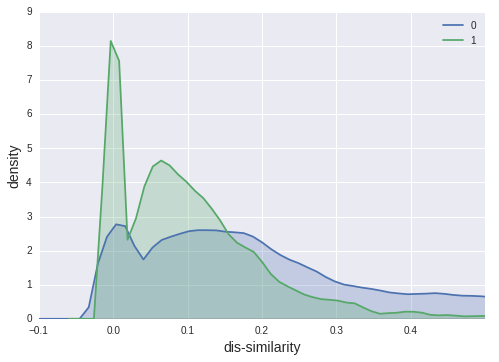

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for data, label in zip([sample_qs['dis'][sample_qs['is_duplicate']==0], 
                        sample_qs['dis'][sample_qs['is_duplicate']==1]], 
                       ["0", "1"]):
    sns.kdeplot(data,  ax=ax, label = label, kernel = 'epa', shade = True)
    
ax.set_xlim([-0.1, .5])
plt.xlabel('dis-similarity', fontsize=14)
plt.ylabel('density', fontsize=14)

plt.show()

## Significant?

In [22]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
log_model = smf.glm('is_duplicate ~ dis', 
        data = sample_qs, family = sm.families.Binomial()).fit()
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           is_duplicate   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -6201.5
Date:                Wed, 12 Jul 2017   Deviance:                       12403.
Time:                        11:21:32   Pearson chi2:                 1.14e+04
No. Iterations:                     5                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0824      0.030      2.731      0.006       0.023       0.142
dis           -3.4099      0.141    -24.235      0.000      -3.686      -3.134
==============================================================================
"""

The low p value from the logistic model indicates it is very unlikely changes in the dissimilarity score are not related to if a question is a duplicate.

# Sentiment

In [23]:
from textblob import TextBlob

def sentiment(question):
    
    pol_sub = [TextBlob(question).sentiment.polarity, 
               TextBlob(question).sentiment.subjectivity]
    return pol_sub           



In [24]:
question1_sent_subj = sample_qs['question1'].apply(sentiment)
sample_qs['polarity1'], sample_qs['subjectivity1'] = zip(*question1_sent_subj)

In [25]:
question1_sent_subj2 = sample_qs['question2'].apply(sentiment)
sample_qs['polarity2'], sample_qs['subjectivity2'] = zip(*question1_sent_subj2)

In [26]:
sample_qs.head()

,id,qid1,qid2,question1,question2,is_duplicate,dis,polarity1,subjectivity1,polarity2,subjectivity2
8067,8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0,2.554083e-01,0.00,0.00,0.00,0.000
368101,368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0,9.896066e-02,1.00,0.30,0.05,0.775
70497,70497,121486,121487,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0,4.205735e-01,0.50,0.50,1.00,0.300
226567,226567,254474,258192,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1,1.704767e-07,0.25,0.25,0.25,0.250
73186,73186,48103,3062,How close we are to see 3rd world war?,How close is a World War III?,1,-1.590667e-08,0.00,0.00,0.00,0.000


In [44]:
sample_qs['pol_diff'] = sample_qs['polarity1'] - sample_qs['polarity2']
sample_qs['subj_diff'] = sample_qs['subjectivity1'] - sample_qs['subjectivity2']

In [45]:
sample_qs[['pol_diff', 'subj_diff', 'is_duplicate']].groupby('is_duplicate').describe()

pol_diff                                                     \
                count      mean       std  min       25%  50%  75%   max   
is_duplicate                                                               
0              6265.0 -0.004583  0.323645 -2.0 -0.011364  0.0  0.0  2.00   
1              3735.0 -0.002473  0.288899 -1.8  0.000000  0.0  0.0  1.65   

             subj_diff                                                     
                 count      mean       std  min       25%  50%   75%  max  
is_duplicate                                                               
0               6265.0 -0.006941  0.328057 -1.0 -0.083333  0.0  0.05  1.0  
1               3735.0 -0.005723  0.273179 -1.0  0.000000  0.0  0.00  1.0

In [47]:
log_model = smf.glm('is_duplicate ~ pol_diff * subj_diff', 
        data = sample_qs, family = sm.families.Binomial()).fit()
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           is_duplicate   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9996
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -6607.8
Date:                Wed, 12 Jul 2017   Deviance:                       13216.
Time:                        12:13:51   Pearson chi2:                 1.00e+04
No. Iterations:                     4                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.5183      0.021    -24.777      0.000      -0.559      -0.477
pol_diff               0.0215      0.069      0.314      0.753      -0.113       0.156
subj_diff              0.0079      0.069      0.114      0.909      -0.127       0.143
pol_diff:subj_diff     0.0514      0.139      0.369      0.712      -0.222       0.324
======================================================================================
"""

# Counting different words

In [28]:
print(sample_qs['question1'].iloc[30])
print(sample_qs['question2'].iloc[30])

What is your review of Suicide Squad (2016 movie)?
How would you fix Suicide Squad?


In [29]:
def different_words(question_pair):
    
    parsed1 = clean_text(question_pair[0])
    parsed2 = clean_text(question_pair[1])
    diff1 = [word for word in parsed1 if word not in parsed2]
    diff2 = [word for word in parsed2 if word not in parsed1]
    return len((diff1 + diff2))
    #return diff1 + diff2

In [30]:
test = sample_qs[['question1', 'question2']].iloc[100]

In [31]:
print(different_words(test))
print(test[0])
print(test[1])

2
How can you tell if someone has blocked you on iPhone?
How do I know if someone has blocked me on their iPhone?


In [32]:
diff_lens = sample_qs[['question1', 'question2']].apply(different_words, axis = 1)

In [33]:
sample_qs['num_unmatched_words'] = diff_lens
sample_qs.head()

,id,qid1,qid2,question1,question2,is_duplicate,dis,polarity1,subjectivity1,polarity2,subjectivity2,num_unmatched_words
8067,8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0,2.554083e-01,0.00,0.00,0.00,0.000,2
368101,368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0,9.896066e-02,1.00,0.30,0.05,0.775,4
70497,70497,121486,121487,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0,4.205735e-01,0.50,0.50,1.00,0.300,10
226567,226567,254474,258192,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1,1.704767e-07,0.25,0.25,0.25,0.250,0
73186,73186,48103,3062,How close we are to see 3rd world war?,How close is a World War III?,1,-1.590667e-08,0.00,0.00,0.00,0.000,2


In [34]:
sample_qs[['is_duplicate', 'num_unmatched_words']].groupby('is_duplicate').describe()

num_unmatched_words                                              
                           count      mean       std  min  25%  50%  75%   max
is_duplicate                                                                  
0                         6265.0  5.894174  4.840740  0.0  2.0  5.0  8.0  35.0
1                         3735.0  2.605355  2.392313  0.0  1.0  2.0  4.0  16.0

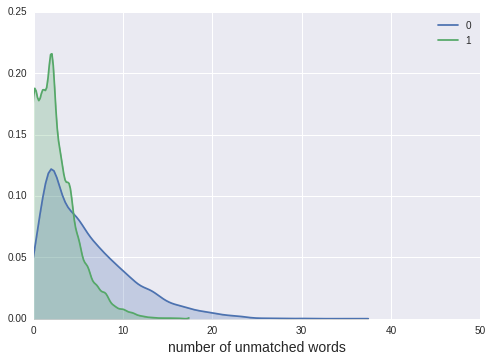

In [38]:
fig, ax = plt.subplots()

for num, label in zip([sample_qs['num_unmatched_words'][sample_qs['is_duplicate']==0], 
                       sample_qs['num_unmatched_words'][sample_qs['is_duplicate']==1]], 
                      ['0','1']):
    sns.kdeplot(num,  ax=ax, label = label, kernel = 'gau', shade = True)

ax.set_xlim([0, 50])
plt.xlabel("number of unmatched words", fontsize = 14)
plt.show()
 

In [39]:
log_model = smf.glm('is_duplicate ~ num_unmatched_words', 
                    data = sample_qs, family = sm.families.Binomial()).fit()
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           is_duplicate   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -5761.8
Date:                Wed, 12 Jul 2017   Deviance:                       11524.
Time:                        12:00:59   Pearson chi2:                 9.67e+03
No. Iterations:                     5                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.5326      0.035     15.417      0.000       0.465       0.600
num_unmatched_words    -0.2705      0.008    -33.224      0.000      -0.286      -0.255
=======================================================================================
"""